## Visualizing and understanding the data available.

In [99]:
# Install the necessary packages
!pip install torch torchvision albumentations tqdm opencv-python

# Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
from glob import glob
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from albumentations import HorizontalFlip, VerticalFlip, Rotate
import tqdm
import cv2

# Configure matplotlib
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
%matplotlib inline


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


## Loading the dataset

In [100]:
train_data = pd.read_csv('/Users/elizabethnemeti/Desktop/uw-madison-gi-tract-image-segmentation/train.csv')

In [101]:
train_data.head()

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


In [102]:
train_images = glob('/Users/elizabethnemeti/Desktop/uw-madison-gi-tract-image-segmentation/train/*/*/*/*')

In [103]:
len(train_images)

38496

In [104]:
train_images[0]

'/Users/elizabethnemeti/Desktop/uw-madison-gi-tract-image-segmentation/train/case22/case22_day0/scans/slice_0131_266_266_1.50_1.50.png'

## Plotting a few images to visualize data randomly

**Each case has 144 scans, with a few being segmentation masks.
It is to be noted that not all cases have masks**

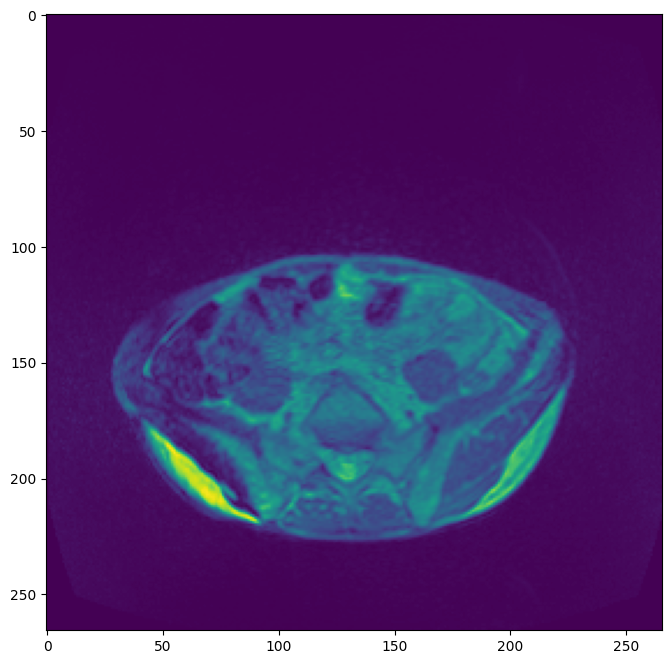

In [105]:
image = cv2.imread(train_images[0], cv2.IMREAD_UNCHANGED)
plt.imshow(image)

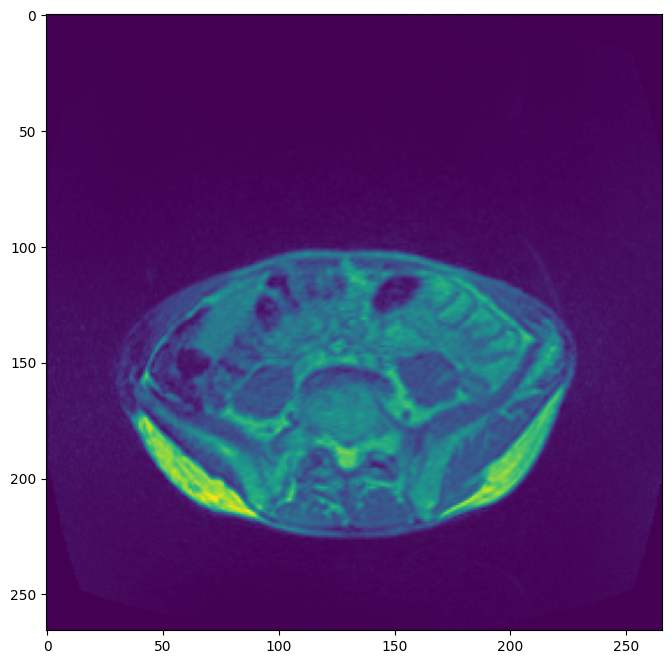

In [106]:
image = cv2.imread(train_images[143], cv2.IMREAD_UNCHANGED)
plt.imshow(image)

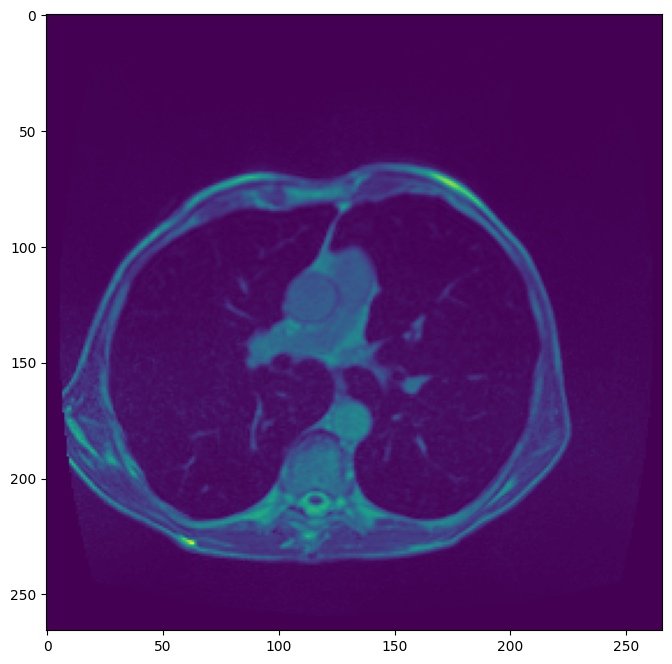

In [107]:
image = cv2.imread(train_images[1], cv2.IMREAD_UNCHANGED)
plt.imshow(image)

## Run Length Encoding (RLE) images decoding

The segmentation (where doesn't have the value nan) is formed by a list of numbers containing different pixel points and their length. As an example:

'28094 3 28358 7 28623 9 28889 9 29155 9 29421 9 29687 9 29953 9 30219 9 30484 10 30750 10 31016 10 31282 10 31548 10 31814 10 32081 9 32347 8 32614 6'

where:

28094, 28358, 28623 etc. are the startpoints of the pixels within the matrix
and 3, 7, 9, 9 etc. are how long to strech the startpoints - meaning the total length
hence we can compute the endpoint of each of these segments as the sum of startpoints + endpoints

In [108]:
def rle2mask(mask_rle, shape):
    if mask_rle == '':
        return np.zeros(shape[0] * shape[1], dtype=np.uint8).reshape(shape)
    s = mask_rle.split(" ")
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    ends = starts + lengths - 1
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for low, high in zip(starts-1, ends):
        img[low : high] = 1
    return img.reshape(shape)

Use `pathToInfo` to Extract Metadata for All Images

In [109]:
def pathToInfo(path):
    try:
        path_segments = path.split('/')
        if len(path_segments) < 8:
            raise ValueError("Path does not contain enough segments")
        
        caseDay = path_segments[5]
        slice_no = path_segments[7].split('_')[1]
        id = caseDay + '_slice_' + slice_no
        
        details = path_segments[7].split('_')
        if len(details) < 6:
            raise ValueError("Path details segment does not contain enough parts")
        
        height = details[2]
        width = details[3]
        h_spacing = details[4]
        w_spacing = details[5][:-4]  # Remove the file extension
        
        return pd.Series([id, height, width, h_spacing, w_spacing])
    
    except IndexError:
        print(f"IndexError processing path: {path}")
        return pd.Series([None, None, None, None, None])
    except ValueError as ve:
        print(f"ValueError: {ve} for path: {path}")
        return pd.Series([None, None, None, None, None])

In [110]:
# Create a DataFrame from the image paths
path_details_df = pd.DataFrame(train_images, columns=['path'])

# Apply the function to extract details and create columns for id, height, width, h_spacing, w_spacing
path_details_df[['id', 'height', 'width', 'h_spacing', 'w_spacing']] = path_details_df['path'].apply(func=lambda x: pathToInfo(x))

# Check the resulting DataFrame
path_details_df.head()

# Merge the new DataFrame with the existing one
new_df = df.merge(path_details_df, on='id')

# Save the new DataFrame to CSV
new_df.to_csv('./train_dataset.csv', index=False)

ValueError: Path details segment does not contain enough parts for path: /Users/elizabethnemeti/Desktop/uw-madison-gi-tract-image-segmentation/train/case22/case22_day0/scans/slice_0131_266_266_1.50_1.50.png
ValueError: Path details segment does not contain enough parts for path: /Users/elizabethnemeti/Desktop/uw-madison-gi-tract-image-segmentation/train/case22/case22_day0/scans/slice_0032_266_266_1.50_1.50.png
ValueError: Path details segment does not contain enough parts for path: /Users/elizabethnemeti/Desktop/uw-madison-gi-tract-image-segmentation/train/case22/case22_day0/scans/slice_0084_266_266_1.50_1.50.png
ValueError: Path details segment does not contain enough parts for path: /Users/elizabethnemeti/Desktop/uw-madison-gi-tract-image-segmentation/train/case22/case22_day0/scans/slice_0092_266_266_1.50_1.50.png
ValueError: Path details segment does not contain enough parts for path: /Users/elizabethnemeti/Desktop/uw-madison-gi-tract-image-segmentation/train/case22/case22_day0/scan

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [111]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115488 entries, 0 to 115487
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            115488 non-null  object
 1   class         115488 non-null  object
 2   segmentation  33913 non-null   object
dtypes: object(3)
memory usage: 2.6+ MB


In [112]:
train_seg = train_data.dropna()

In [113]:
train_seg.head()

,id,class,segmentation
194,case123_day20_slice_0065,stomach,28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...
197,case123_day20_slice_0066,stomach,27561 8 27825 11 28090 13 28355 14 28620 15 28...
200,case123_day20_slice_0067,stomach,15323 4 15587 8 15852 10 16117 11 16383 12 166...
203,case123_day20_slice_0068,stomach,14792 5 15056 9 15321 11 15587 11 15852 13 161...
206,case123_day20_slice_0069,stomach,14526 6 14789 12 15054 14 15319 16 15584 17 15...


In [114]:
train_seg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33913 entries, 194 to 115465
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            33913 non-null  object
 1   class         33913 non-null  object
 2   segmentation  33913 non-null  object
dtypes: object(3)
memory usage: 1.0+ MB


In [115]:
train_seg['segmentation'].iloc[0]

'28094 3 28358 7 28623 9 28889 9 29155 9 29421 9 29687 9 29953 9 30219 9 30484 10 30750 10 31016 10 31282 10 31548 10 31814 10 32081 9 32347 8 32614 6'

In [116]:
mask1 = rle2mask(train_seg['segmentation'].iloc[0], image.shape)

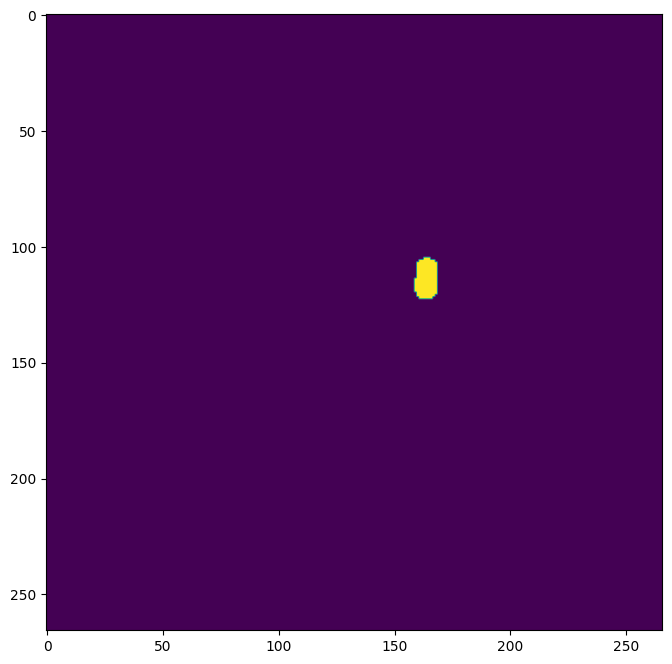

In [117]:
plt.imshow(mask1)

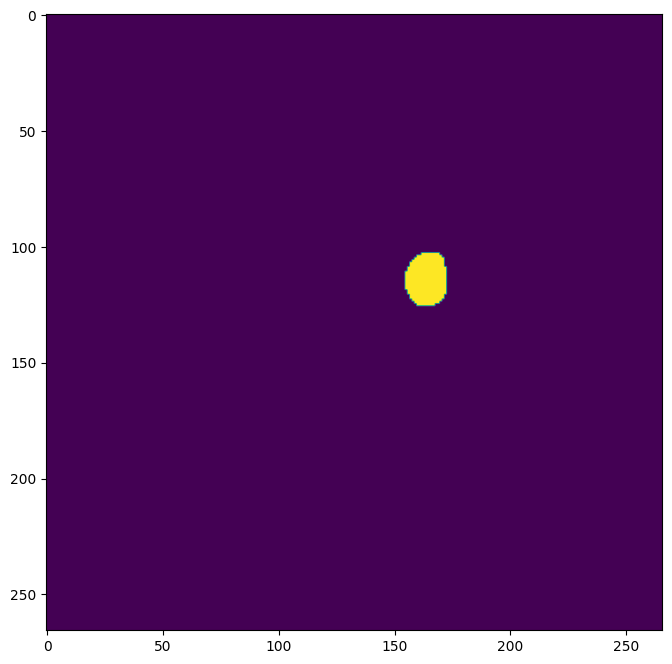

In [118]:
mask2 = rle2mask(train_seg['segmentation'].iloc[1], image.shape)
plt.imshow(mask2)

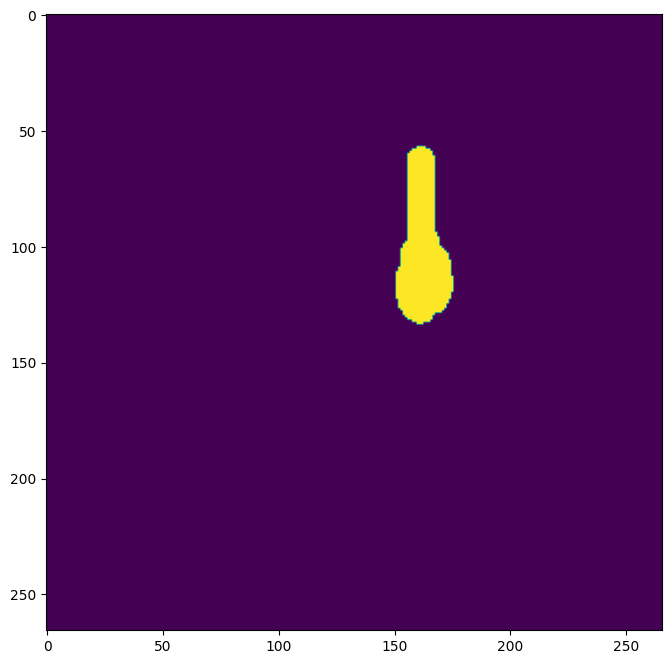

In [119]:
mask3 = rle2mask(train_seg['segmentation'].iloc[2], image.shape)
plt.imshow(mask3)

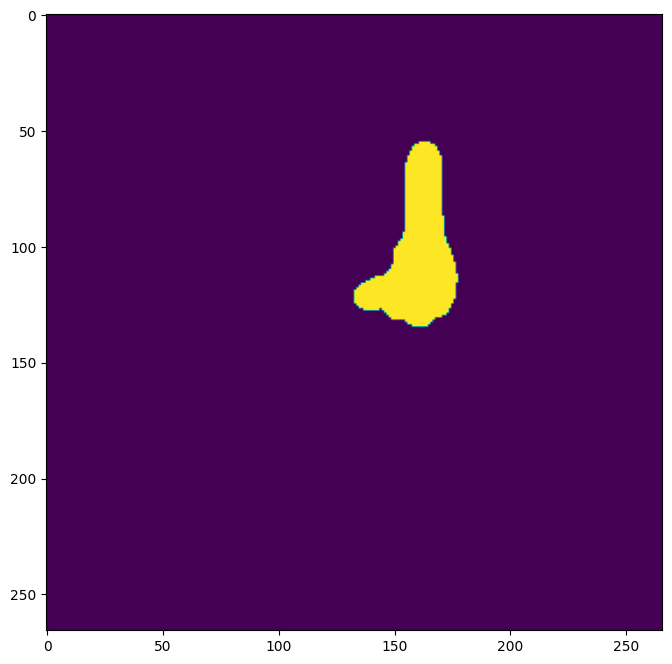

In [120]:
mask4 = rle2mask(train_seg['segmentation'].iloc[3], image.shape)
plt.imshow(mask4)

## Moving towards making a little more sense of masks

In [121]:
train_seg['class'].value_counts()

class
large_bowel    14085
small_bowel    11201
stomach         8627
Name: count, dtype: int64

In [122]:
train_seg[['case', 'day','_', 'slice']] = train_seg['id'].str.split('_', expand=True)

/var/folders/fm/j8jgcsf90d1g6lkqzrw2mptw0000gn/T/ipykernel_1501/3778118854.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_seg[['case', 'day','_', 'slice']] = train_seg['id'].str.split('_', expand=True)
/var/folders/fm/j8jgcsf90d1g6lkqzrw2mptw0000gn/T/ipykernel_1501/3778118854.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_seg[['case', 'day','_', 'slice']] = train_seg['id'].str.split('_', expand=True)
/var/folders/fm/j8jgcsf90d1g6lkqzrw2mptw0000gn/T/ipykernel_1501/3778118854.py:1: Setti

In [123]:
train_seg.drop('_', axis=1, inplace=True)

/var/folders/fm/j8jgcsf90d1g6lkqzrw2mptw0000gn/T/ipykernel_1501/3157862534.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_seg.drop('_', axis=1, inplace=True)


In [124]:
train_seg.head()

,id,class,segmentation,case,day,slice
194,case123_day20_slice_0065,stomach,28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...,case123,day20,0065
197,case123_day20_slice_0066,stomach,27561 8 27825 11 28090 13 28355 14 28620 15 28...,case123,day20,0066
200,case123_day20_slice_0067,stomach,15323 4 15587 8 15852 10 16117 11 16383 12 166...,case123,day20,0067
203,case123_day20_slice_0068,stomach,14792 5 15056 9 15321 11 15587 11 15852 13 161...,case123,day20,0068
206,case123_day20_slice_0069,stomach,14526 6 14789 12 15054 14 15319 16 15584 17 15...,case123,day20,0069


In [125]:
train_seg['case'] = train_seg['case'].str.replace('case', '')

/var/folders/fm/j8jgcsf90d1g6lkqzrw2mptw0000gn/T/ipykernel_1501/2314378466.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_seg['case'] = train_seg['case'].str.replace('case', '')


In [126]:
train_seg['day'] = train_seg['day'].str.replace('day', '')

/var/folders/fm/j8jgcsf90d1g6lkqzrw2mptw0000gn/T/ipykernel_1501/93224464.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_seg['day'] = train_seg['day'].str.replace('day', '')


In [127]:
train_seg.head()

,id,class,segmentation,case,day,slice
194,case123_day20_slice_0065,stomach,28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...,123,20,0065
197,case123_day20_slice_0066,stomach,27561 8 27825 11 28090 13 28355 14 28620 15 28...,123,20,0066
200,case123_day20_slice_0067,stomach,15323 4 15587 8 15852 10 16117 11 16383 12 166...,123,20,0067
203,case123_day20_slice_0068,stomach,14792 5 15056 9 15321 11 15587 11 15852 13 161...,123,20,0068
206,case123_day20_slice_0069,stomach,14526 6 14789 12 15054 14 15319 16 15584 17 15...,123,20,0069


In [128]:
train_data['id'].value_counts()

id
case123_day20_slice_0001    3
case55_day18_slice_0091     3
case55_day18_slice_0093     3
case55_day18_slice_0094     3
case55_day18_slice_0095     3
                           ..
case49_day13_slice_0049     3
case49_day13_slice_0050     3
case49_day13_slice_0051     3
case49_day13_slice_0052     3
case30_day0_slice_0144      3
Name: count, Length: 38496, dtype: int64

In [129]:
enum = ['stomach', 'large_bowel', 'small_bowel']

In [130]:
unique_ids = train_data['id'].unique()

In [131]:
unique_ids

array(['case123_day20_slice_0001', 'case123_day20_slice_0002',
       'case123_day20_slice_0003', ..., 'case30_day0_slice_0142',
       'case30_day0_slice_0143', 'case30_day0_slice_0144'], dtype=object)

In [132]:
for id in unique_ids:
    idx = train_data[train_data.id == id]
    print(idx)
    break

                         id        class segmentation
0  case123_day20_slice_0001  large_bowel          NaN
1  case123_day20_slice_0001  small_bowel          NaN
2  case123_day20_slice_0001      stomach          NaN


In [133]:
df = pd.DataFrame()
df['id'] = unique_ids
df['stomach_rle'] = pd.Series(dtype='string')
df['large_bowel_rle'] = pd.Series(dtype='string')
df['small_bowel_rle'] = pd.Series(dtype='string')

In [134]:
df.head()

,id,stomach_rle,large_bowel_rle,small_bowel_rle
0,case123_day20_slice_0001,<NA>,<NA>,<NA>
1,case123_day20_slice_0002,<NA>,<NA>,<NA>
2,case123_day20_slice_0003,<NA>,<NA>,<NA>
3,case123_day20_slice_0004,<NA>,<NA>,<NA>
4,case123_day20_slice_0005,<NA>,<NA>,<NA>


TODO: Vectorize the following code for speed up

In [135]:
for i, id in enumerate(unique_ids):
    idx = train_data[train_data.id == id]
    for index, row in idx.iterrows():
        rle = row['segmentation']
        if row['class'] == 'stomach':
            df.at[i,'stomach_rle'] = rle
        elif row['class'] == 'large_bowel':
            df.at[i,'large_bowel_rle'] = rle
        elif row['class'] == 'small_bowel':
            df.at[i,'small_bowel_rle'] = rle

In [136]:
df

,id,stomach_rle,large_bowel_rle,small_bowel_rle
0,case123_day20_slice_0001,<NA>,<NA>,<NA>
1,case123_day20_slice_0002,<NA>,<NA>,<NA>
2,case123_day20_slice_0003,<NA>,<NA>,<NA>
3,case123_day20_slice_0004,<NA>,<NA>,<NA>
4,case123_day20_slice_0005,<NA>,<NA>,<NA>
...,...,...,...,...
38491,case30_day0_slice_0140,<NA>,<NA>,<NA>
38492,case30_day0_slice_0141,<NA>,<NA>,<NA>
38493,case30_day0_slice_0142,<NA>,<NA>,<NA>
38494,case30_day0_slice_0143,<NA>,<NA>,<NA>


In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38496 entries, 0 to 38495
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               38496 non-null  object
 1   stomach_rle      8627 non-null   string
 2   large_bowel_rle  14085 non-null  string
 3   small_bowel_rle  11201 non-null  string
dtypes: object(1), string(3)
memory usage: 1.2+ MB


Above data indicates that most scans don't have masks

Saving the df to csv, as the above code is for readibility purposes and hence not the most efficient code. 

In [138]:
df.to_csv('./data.csv', index=False)

In [139]:
train_images[0]

'/Users/elizabethnemeti/Desktop/uw-madison-gi-tract-image-segmentation/train/case22/case22_day0/scans/slice_0131_266_266_1.50_1.50.png'

We need to add all these paths to our dataset against their respective cases for easy access of images

In [140]:
df.head()

,id,stomach_rle,large_bowel_rle,small_bowel_rle
0,case123_day20_slice_0001,<NA>,<NA>,<NA>
1,case123_day20_slice_0002,<NA>,<NA>,<NA>
2,case123_day20_slice_0003,<NA>,<NA>,<NA>
3,case123_day20_slice_0004,<NA>,<NA>,<NA>
4,case123_day20_slice_0005,<NA>,<NA>,<NA>


Now we can add all these paths to our dataframe

In [141]:
path_details_df.head()

,path,id,height,width,h_spacing,w_spacing
0,/Users/elizabethnemeti/Desktop/uw-madison-gi-t...,None,None,None,None,None
1,/Users/elizabethnemeti/Desktop/uw-madison-gi-t...,None,None,None,None,None
2,/Users/elizabethnemeti/Desktop/uw-madison-gi-t...,None,None,None,None,None
3,/Users/elizabethnemeti/Desktop/uw-madison-gi-t...,None,None,None,None,None
4,/Users/elizabethnemeti/Desktop/uw-madison-gi-t...,None,None,None,None,None


Now we merge this path_details_df with our previous data df, to have a final dataset

In [142]:
new_df = df.merge(path_details_df, on ='id')
new_df.head()

,id,stomach_rle,large_bowel_rle,small_bowel_rle,path,height,width,h_spacing,w_spacing


Save this dataframe to a csv to reduce computation time later.

In [143]:
new_df.to_csv('./train_dataset.csv')
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               0 non-null      object
 1   stomach_rle      0 non-null      string
 2   large_bowel_rle  0 non-null      string
 3   small_bowel_rle  0 non-null      string
 4   path             0 non-null      object
 5   height           0 non-null      object
 6   width            0 non-null      object
 7   h_spacing        0 non-null      object
 8   w_spacing        0 non-null      object
dtypes: object(6), string(3)
memory usage: 132.0+ bytes


Plotting scans and their masks

In [144]:
new_df = new_df.fillna('')

In [145]:
new_df.head()

,id,stomach_rle,large_bowel_rle,small_bowel_rle,path,height,width,h_spacing,w_spacing


In [146]:
for idx, row in new_df[(new_df['stomach_rle'] != '')].iloc[20:21,:].iterrows():
    fig, axis = plt.subplots(1,4)
    image = cv2.imread(row['path'], cv2.IMREAD_UNCHANGED)
    axis[0].imshow(image, cmap='gray')
    axis[1].imshow(rle2mask(row['stomach_rle'], (int(row['width']), int(row['height']))), cmap='gray')
    axis[2].imshow(rle2mask(row['large_bowel_rle'], (int(row['width']), int(row['height']))), cmap='gray')
    axis[3].imshow(rle2mask(row['small_bowel_rle'], (int(row['width']), int(row['height']))), cmap='gray')
    print(row)

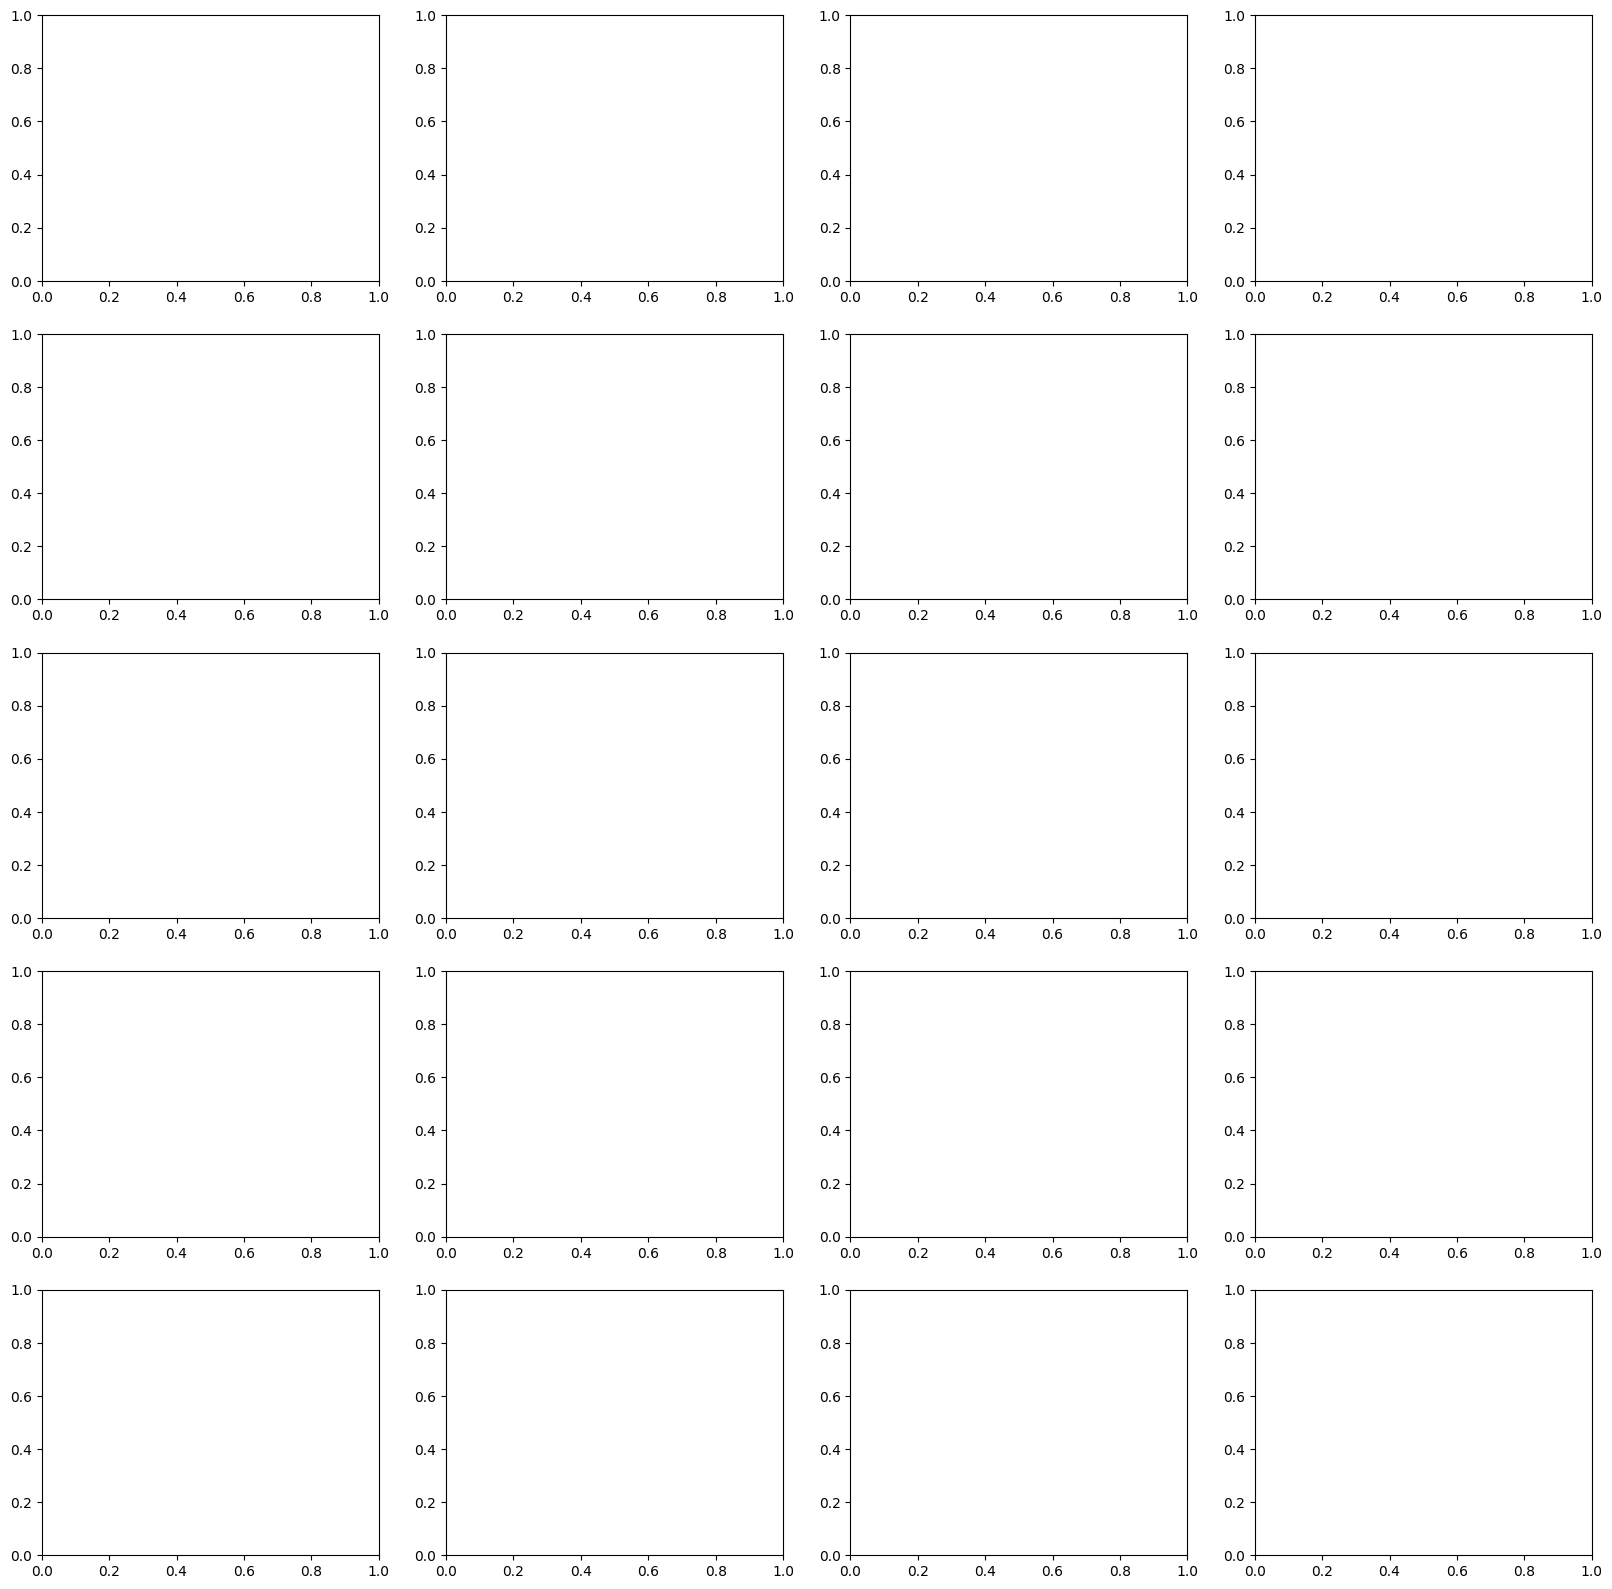

In [147]:
rcParams['figure.figsize'] = 20, 20
fig, axis = plt.subplots(5,4)
i = 0
for idx, row in new_df[new_df['stomach_rle'] != ''].iloc[18:23,:].iterrows():
    image = cv2.imread(row['path'], cv2.IMREAD_UNCHANGED)
    axis[i,0].imshow(image, cmap='gray')
    axis[i,1].imshow(rle2mask(row['stomach_rle'], (int(row['width']), int(row['height']))), cmap='gray')
    axis[i,2].imshow(rle2mask(row['large_bowel_rle'], (int(row['width']), int(row['height']))), cmap='gray')
    axis[i,3].imshow(rle2mask(row['small_bowel_rle'], (int(row['width']), int(row['height']))), cmap='gray')
    i += 1

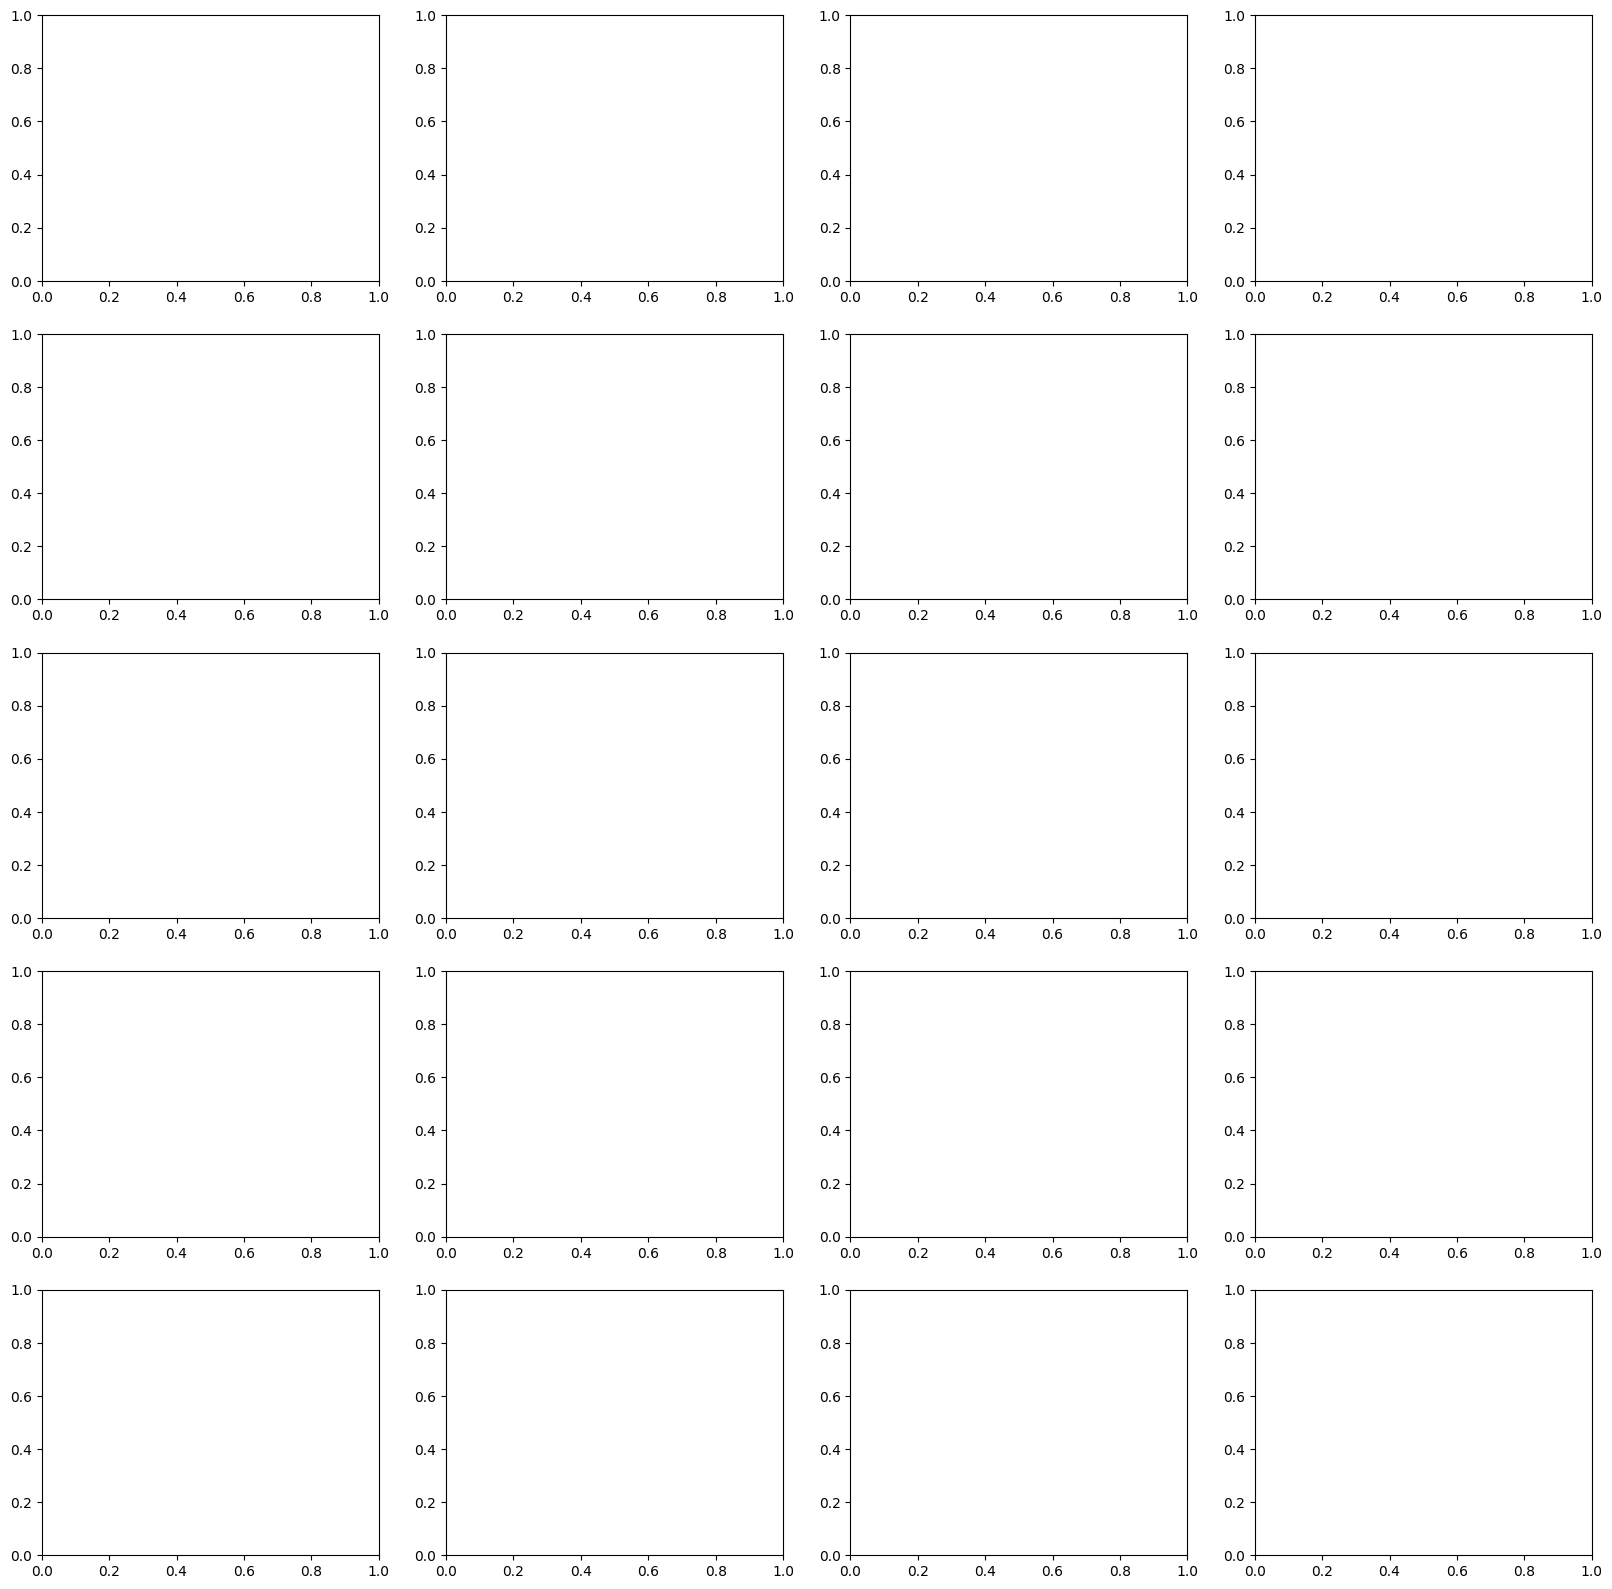

In [148]:
rcParams['figure.figsize'] = 20, 20
fig, axis = plt.subplots(5,4)
i = 0
for idx, row in new_df[new_df['stomach_rle'] != ''].iloc[10:15,:].iterrows():
    image = cv2.imread(row['path'], cv2.IMREAD_UNCHANGED)
    axis[i,0].imshow(image, cmap='gray')
    axis[i,1].imshow(rle2mask(row['stomach_rle'], (int(row['width']), int(row['height']))), cmap='gray')
    axis[i,2].imshow(rle2mask(row['large_bowel_rle'], (int(row['width']), int(row['height']))), cmap='gray')
    axis[i,3].imshow(rle2mask(row['small_bowel_rle'], (int(row['width']), int(row['height']))), cmap='gray')
    i += 1

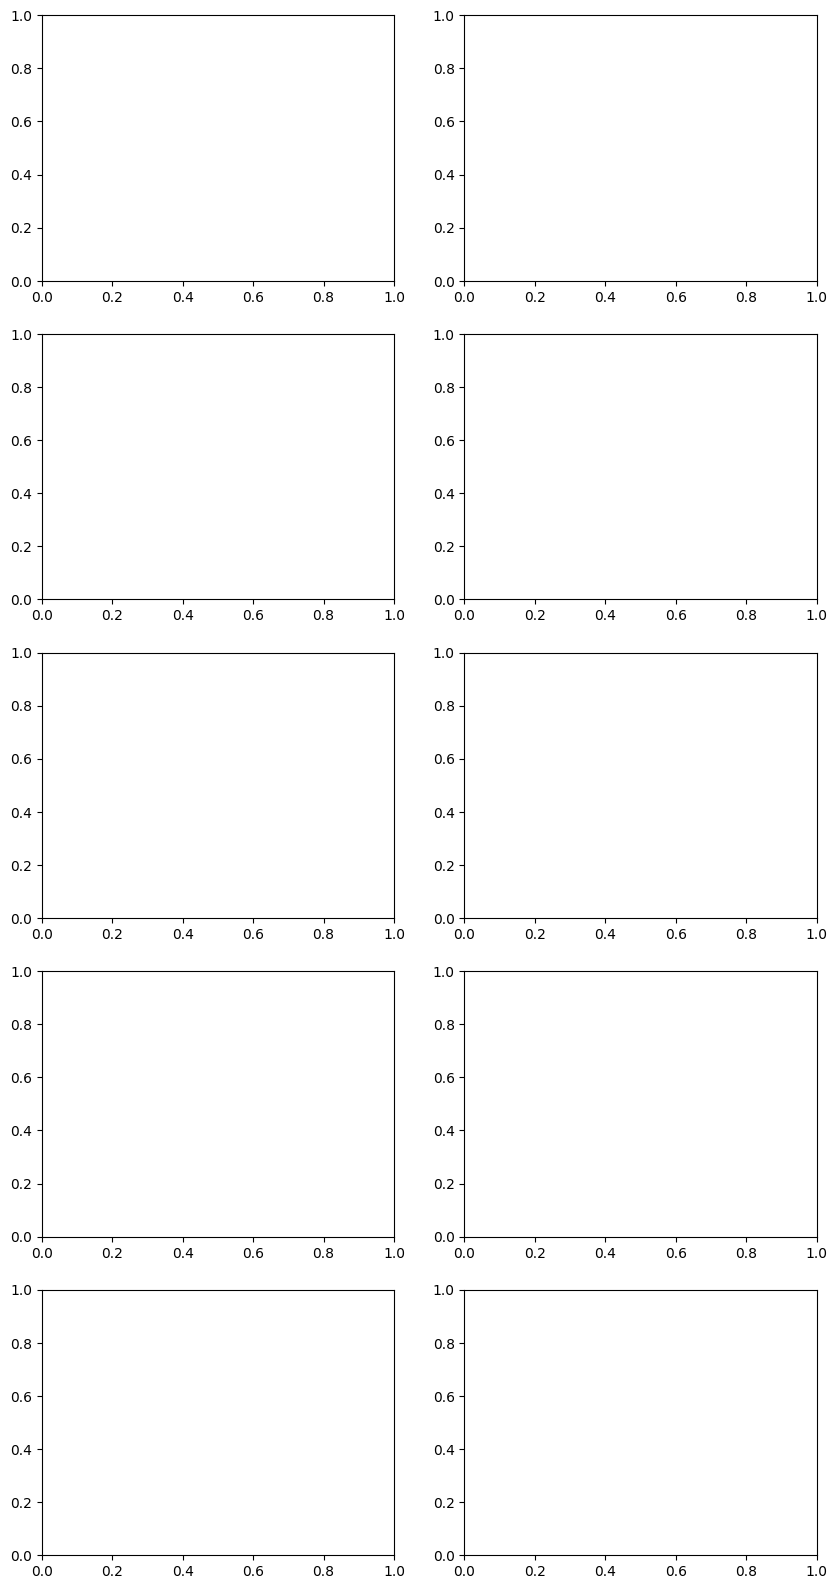

In [149]:
rcParams['figure.figsize'] = 10,20
fig, axis = plt.subplots(5,2)
i = 0
for idx, row in new_df[(new_df['stomach_rle'] != '')].iloc[18:23,:].iterrows():
    image = cv2.imread(row['path'], cv2.IMREAD_UNCHANGED)
    axis[i,0].imshow(image, cmap='gray')
    s_mask = rle2mask(row['stomach_rle'], (int(row['width']), int(row['height'])))
    lb_mask = rle2mask(row['large_bowel_rle'], (int(row['width']), int(row['height'])))
    sb_mask = rle2mask(row['small_bowel_rle'], (int(row['width']), int(row['height'])))
    
    mask = s_mask + lb_mask + sb_mask
    
    axis[i,1].imshow(mask, cmap='gray')
    i += 1